# Supervised Learning (Regression): Predicting Product Sales

## Context

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also certain attributes of each product and store have been defined. The aim of this project is to build a predictive model and determine the sales of each product at a particular store. Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales. Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence it will be required to treat them accordingly.

## Objective

To build a predictive model and find out the sales of each product at a particular store. We will then provide recommendations to the BigMart sales team to understand the properties of products and stores which play a key role in increasing sales.

## Data Dictionary

- **Item_Identifier** : Unique product ID

- **Item_Weight** : Weight of product

- **Item_Fat_Content** : Whether the product is low fat or not

- **Item_Visibility** : The % of the total display area of all products in a store allocated to the particular product

- **Item_Type** : The category to which the product belongs

- **Item_MRP** : Maximum Retail Price (list price) of the product

- **Outlet_Identifier** : Unique store ID

- **Outlet_Establishment_Year** : The year in which the store was established

- **Outlet_Size** : The size of the store in terms of ground area covered

- **Outlet_Location_Type** : The type of city in which the store is located

- **Outlet_Type** : Whether the outlet is just a grocery store or some sort of supermarket

- **Item_Outlet_Sales** : Sales of the product in the particular store. This is the outcome variable to be predicted.

We have two datasets - train (8523) and test (5681) data. The train dataset has both input and output variable(s). You need to predict the sales for the test dataset.

## Loading libraries and overview of datasets

In [1]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd

# Import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for constructing linear regression models
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import libraries for scaling data
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Loading datasets

In [3]:
# Import library necessary for file uploads
from google.colab import files
# Request the upload of the training data file
train_upload = files.upload()
# Load both the training and testing datasets
train_df = pd.read_csv('Train.csv')
# Request the upload of the testing data file
test_upload = files.upload()
test_df = pd.read_csv('Test.csv')

Saving Train.csv to Train.csv


Saving Test.csv to Test.csv


In [4]:
# Print the first 5 entries in the dataset
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### Observations:

- As the variables `Item_Identifier` and `Outlet_Identifier` are only ID variables, we can probably assume that they don't have any predictive power to over the dependent variable - `Item_Outlet_Sales`.
- We can go ahead and remove these two variables from both the datasets.

In [5]:
# Remove the two ID variables
train_df = train_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
test_df = test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

Now we can get some more information about the dataset, including the total number of observations in the dataset, the names of the columns, and the columns associated data types, etc.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


#### Observations:

- The train datasets has **8523** observations and **10** columns. 
- Two columns: `Item_Weight` and `Outlet_Size` have some missing values as their non-null values is less the total number of observations in the dataset. 
- We can also see that the columns `Item_Fat_Content`, `Item_Type`, `Outlet_Size`, `Outlet_Location_Type` and `Outlet_Type` all have the data type `object`, which tells us that they are strings which means they are likely categorical variables. 
- All other variables are numerical in nature.

Since we have two columns which have missing values in the dataset, let's check the percentage of missing values.

In [7]:
# Print the percentage of missing values per column
(train_df.isnull().sum()/train_df.shape[0])*100

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

Now that we have the percentage of missing values for the columns `Item_Weight` and `Outlet_Size` (~17.16% and ~28.28% respectively), we can move on to treat these missing values.

## EDA and Data Preprocessing

Now that we have an understanding of the business problem which we want to solve and have organized the datasets, the next step would be to obtain a better understanding of the dataset. We can determine the distribution of the variables, the relationships that exist between variables, etc. If there are any data anomalies, such as missing values and outliers, we can also prepare the dataset for building the predictive model by accounting for these anomalies.

### Univariate Analysis

We will begin by exploring the dataset and performing some univariate analysis on the dataset. We will be analyzing and visualizing the dataset, one variable at a time. Data visualization is a very important step, as it helps us better understand the data.

Let's start with analyzing the `categorical` variables present in the data. There are five categorical variables in this dataset, and we will be creating univariate bar charts for each of them to observe their distribution. 

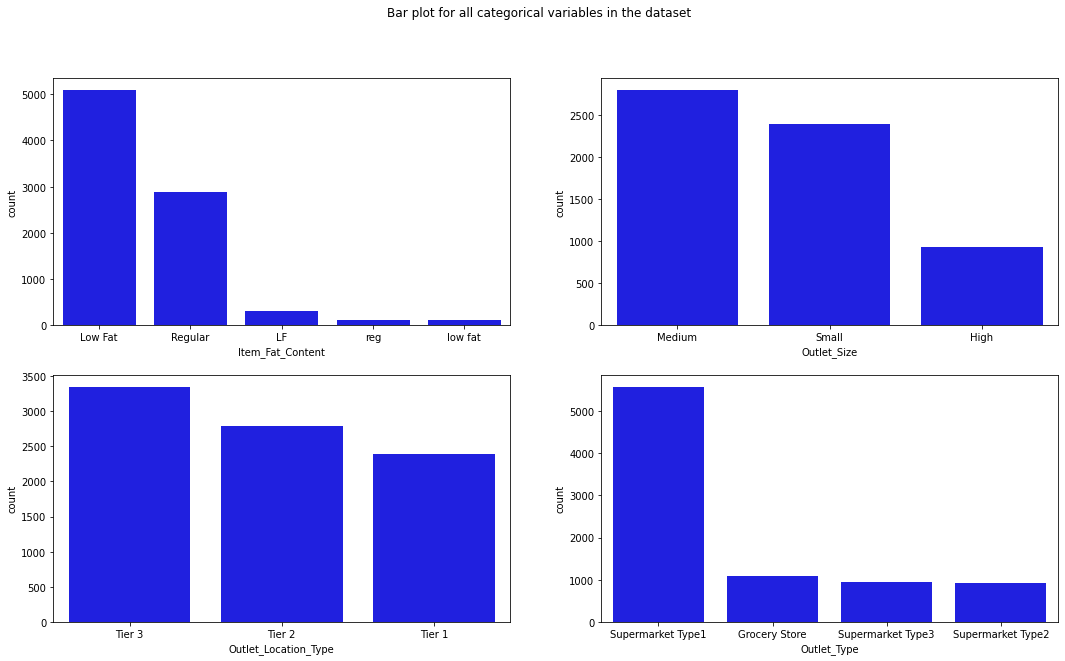

In [8]:
# Plot 4 subplots for each of the categorical variables
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
  
fig.suptitle('Bar plot for all categorical variables in the dataset')
  
sns.countplot(ax=axes[0, 0], x='Item_Fat_Content', data=train_df, color='blue', 
              order=train_df['Item_Fat_Content'].value_counts().index, );

sns.countplot(ax=axes[0, 1], x='Outlet_Size', data=train_df, color='blue', 
              order=train_df['Outlet_Size'].value_counts().index);

sns.countplot(ax=axes[1, 0], x='Outlet_Location_Type', data=train_df, color='blue', 
              order=train_df['Outlet_Location_Type'].value_counts().index);

sns.countplot(ax=axes[1, 1], x='Outlet_Type', data=train_df, color='blue', 
              order=train_df['Outlet_Type'].value_counts().index);

#### Observations:

- From the above univariate plot for the variable `Item_Fat_Content`, it seems like there are errors in the data. The category - `Low Fat` is sometimes also written as `low fat` and `LF`. And also the category `Regular` is also written as `reg` sometimes. So **we need to fix this issue in the data**.
- For the column `Outlet_Size`, we can see that the most common category is - `Medium` followed by Small and High
- The most common category for the column `Outlet_Location_Type` is `Tier 3`, followed by Tier 2 and Tier 1. This makes sense now if we combine this information with the information on column `Outlet_Size`. We would expect High outlet size stores to be present in Tier 1 cities and the count of tier 1 cities is less so the count of high outlets size is also less. And we would expect more number of medium and small number of outlet sizes in the dataset because we have more number outlets present in tier 3 and tier 2 cities in the dataset.
- In the column `Outlet_Type`, the majority of the stores or the model is of `Supermarket Type 1` and we have less and almost equal number of representation in the other categories - Supermarket Type 2 and Supermarket Type 3 and Grocery Store.

Below we are analyzing the categorical variable `Item_Type`. Since it has many more categories, it needs it's own plot.

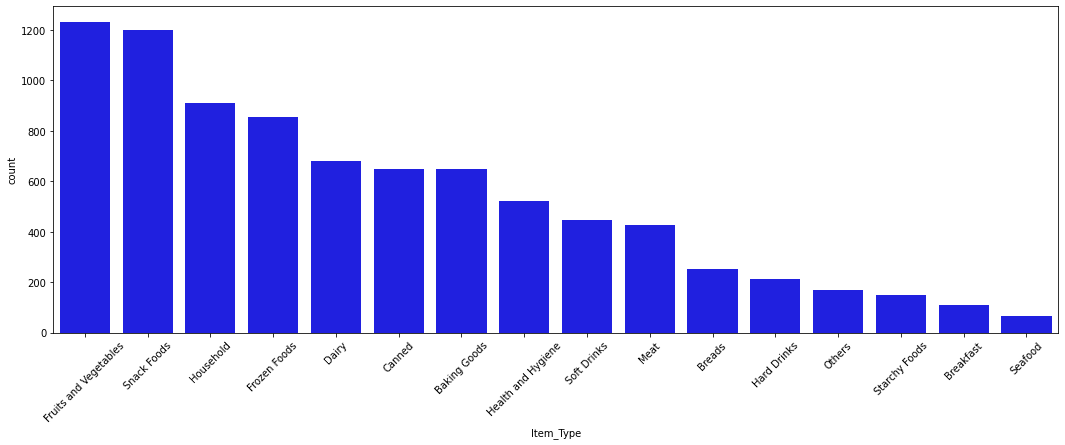

In [9]:
# Plot the last categorical variable
fig= plt.figure(figsize=(18, 6))
sns.countplot(x='Item_Type', data=train_df, color='blue', order=train_df['Item_Type'].value_counts().index);
plt.xticks(rotation=45);

**Observations:**
- We can see that the majority of the the items sold in these stores are `Fruits and Vegetables`, followed by `Snack Foods`, `Household items`, etc.

Before we move on with univariate analysis for the numerical variables, let's first fix the data issues that we have found out for the column `Item_Fat_Content`.

Let's replace the categories `low fat` and `LF` with `Low Fat` using a quick lambda function. We will also we are replace the category `reg` with `Regular`.

In [11]:
# Clean up the Item_Fat_Content labels in the training data
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x=='LF' else x)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='reg' else x)

The data preparation steps that we do on the training data also need to be performed on the testing data.

In [12]:
# Clean up the Item_Fat_Content labels in the training data
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x=='LF' else x)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='reg' else x)

Now we will be analyzing all the `numerical` variables present in the data. Since we want to visualize one numerical variable at a time, a histogram is the best choice to visualize the data.

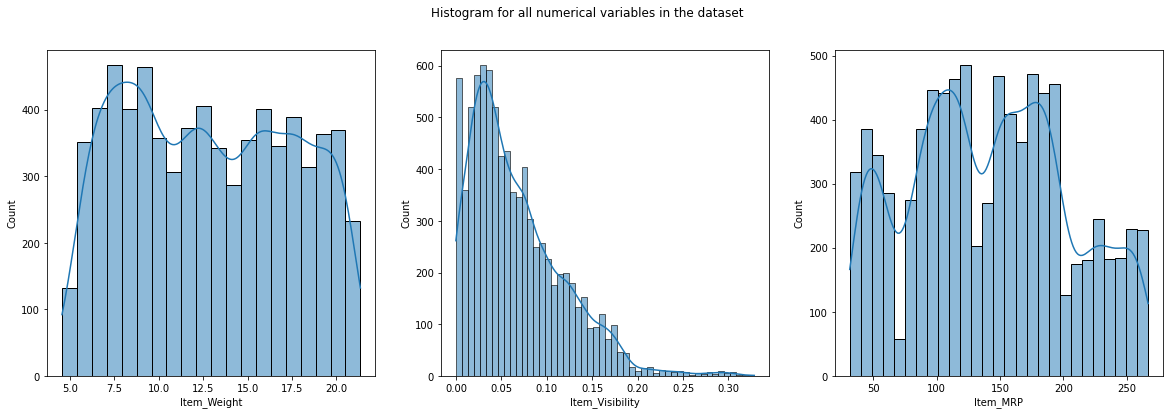

In [13]:
# Plot figures for the numerical variables
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  
fig.suptitle('Histogram for all numerical variables in the dataset')
  
sns.histplot(x='Item_Weight', data=train_df, kde=True, ax=axes[0]);
sns.histplot(x='Item_Visibility', data=train_df, kde=True, ax=axes[1]);
sns.histplot(x='Item_MRP', data=train_df, kde=True, ax=axes[2]);

**Observations:**
- The variable `Item_Weight` is approximately uniformly distributed and when we will impute the missing values for this column, we will need to keep this in mind so we don't end up changing the distribution significantly after imputing those missing values.
- The variable `Item_Visibility` is a heavily right skewed distribution, which suggests that there are certain items whose percentage of display area is much higher than the other items.
- The variable `Item_MRP` is approximately following a multi-modal normal distribution.

### Bivariate Analysis

Now let's move ahead with bivariate analysis. This will help to understand how the variables are related to each other and if there is a strong relationship between dependent and independent variables present in the training dataset. 

In the plot below, we are analyzing the variables `Outlet_Establishment_Year` and `Item_Outlet_Sales`. Since the variable `Outlet_Establishment_Year` is defining a time component, the best chart to analyze this relationship will be a line plot.

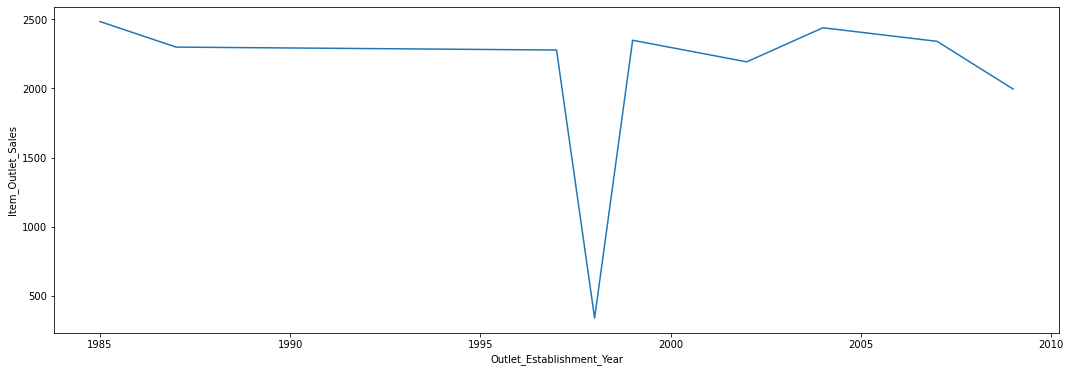

In [14]:
fig= plt.figure(figsize=(18, 6))
sns.lineplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=train_df, ci=None, estimator='mean');

**Observations:**

- The average sales are almost constant every year, but we don't see any increasing/decreasing trend in sales with time. So the variable year might not be a good predictor to predict sales, which we can see later in the modeling phase.
- Also, in the year 1998 the average sales has plummeted. This might be due to some external factors which are not included in the data.

We can now attempt to find linear correlations between the variables. This will help us to discern which numerical variables are highly correlated with the dependent/target variable. We can also observe multi-collinearity, or which pair of independent variables are correlated with each other.

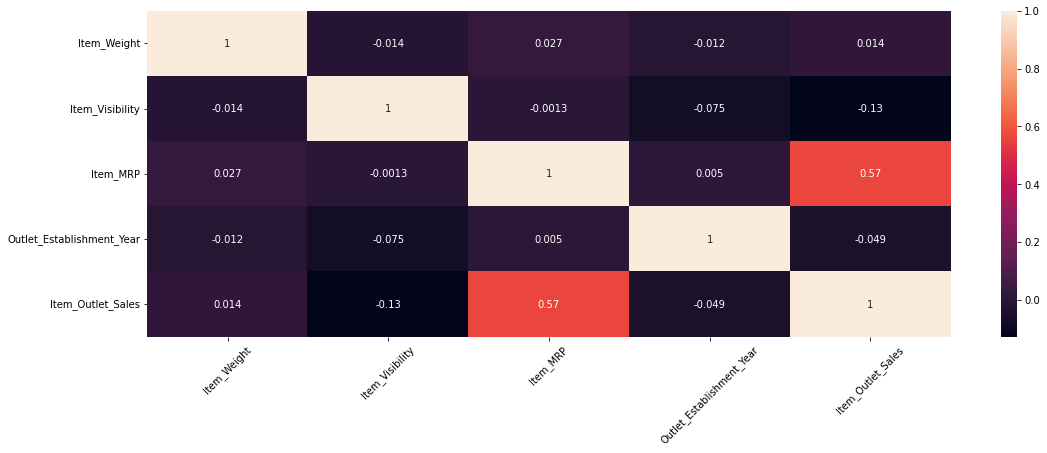

In [15]:
# Plot a correlation heatmap
fig= plt.figure(figsize=(18, 6))
sns.heatmap(train_df.corr(), annot=True);
plt.xticks(rotation=45);

**Observations:**

- It seems like only the independent variable `Item_MRP` has moderate linear relationship with the dependent variable `Item_Outlet_Sales`.
- For the remaining variables it does not seem like there is any strong positive/negative correlation between them.

Now we will create bivariate scatter plots to check relationships between pairs of independent and dependent variables.

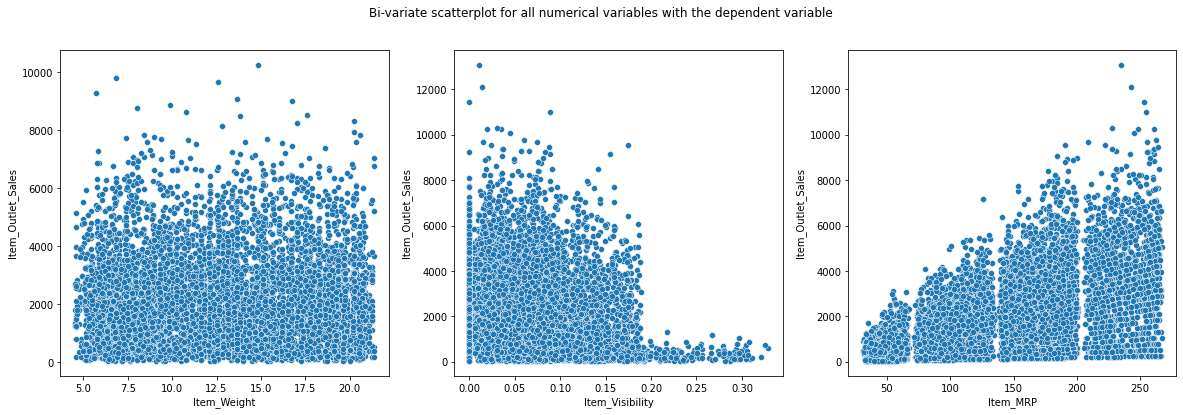

In [16]:
# Plot bivariate scatterplots to observe potential relationships
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  
fig.suptitle('Bi-variate scatterplot for all numerical variables with the dependent variable')
  
sns.scatterplot(x='Item_Weight', y='Item_Outlet_Sales', data=train_df, ax=axes[0]);
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_df, ax=axes[1]);
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=train_df, ax=axes[2]);

**Observations:**

- The first scatter plot shows the data is completely random and there is no visible relationship between `Item_Weight` and `Item_outlet_Sales`. This is also evident from the correlation number. So we can discern that there is no strong correlation between these two variables.
- The second scatter plot between `Item_Visibility` and `Item_outlet_Sales`, there is no good relationship between them, however we can see a pattern as the `Item_Visibility` increases past **0.19**, we see the sales decrease very sharply. This might be due the reason that the management has given more visibility to those items which are not generally sold often, thinking that better visibility could increase the sales. This information can also help us to engineer new features such as a categorical variable with categories: `high visibility` and `low visibility`. This is an idea, we may want to pursue in future.
- The third scatter plot between the variables - `Item_MRP` and `Item_outlet_Sales`, it is clear that there is a positive correlation between them and the variable `Item_MRP` would have a good predictive power to predict the sales.

### Treating the Data with Missing Values

Here we will be imputing missing values for the variable `Item_Weight`. There are many ways to impute missing values. We can impute the missing values by its `mean`, `median`, or also using an advanced imputation algorithm like `kNN`. 

We will try to find some relationship between the variable `Item_Weight` with other variables in the dataset in order to impute those missing values.

**Note:** After imputing the missing values for a variable, the overall distribution of the variable should not change significantly.

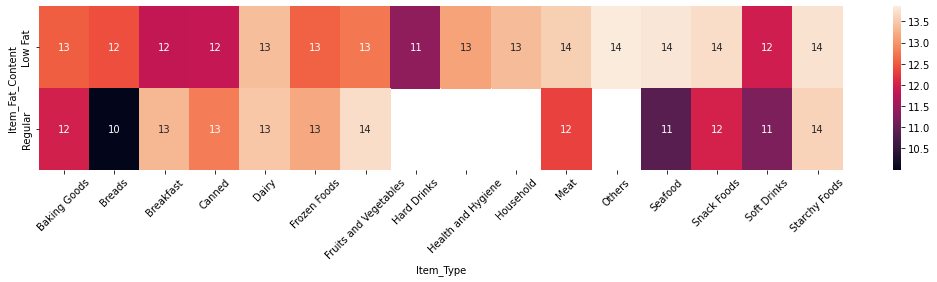

In [17]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Item_Fat_Content', columns='Item_Type', values='Item_Weight'), annot=True);
plt.xticks(rotation=45);

**Observations:**

- We can see that based on different combinations of `Item_Types` and `Item_Fat_Content`, the average range of values for the column `Item_Weight` lies between the minimum value 10 and maximum value of 14

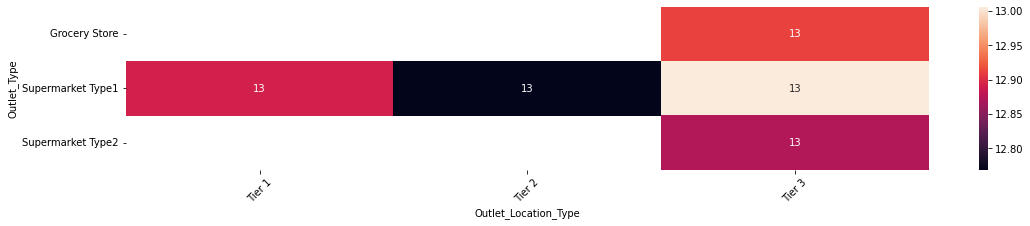

In [18]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Outlet_Type', columns='Outlet_Location_Type', values='Item_Weight'), annot=True);
plt.xticks(rotation=45);

**Observations:**
- We can see that based on different combinations of `Outlet_Type` and `Outlet_Location_Type`, the average range of values for the column `Item_Weight` is constant at 13

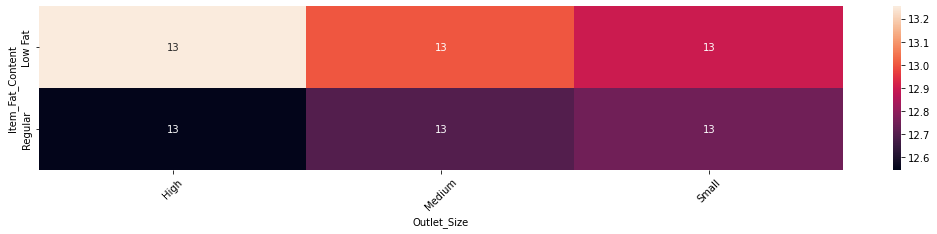

In [19]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Item_Fat_Content', columns='Outlet_Size', values='Item_Weight'), annot=True);
plt.xticks(rotation=45);

**Observations:**
- We can see that based on different combinations of `Item_Fat_Content` and `Outlet_Size`, the average range of values for the column `Item_Weight` is also constant at 13

We will impute the missing values using an uniform distribution with parameters a=10 and b=14.

In [20]:
item_weight_indices_to_be_updated = train_df[train_df['Item_Weight'].isnull()].index
train_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, len(item_weight_indices_to_be_updated))

We will also need to perform the same transformation on the testing dataset.

In [22]:
item_weight_indices_to_be_updated = test_df[test_df['Item_Weight'].isnull()].index
test_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, len(item_weight_indices_to_be_updated))

Next we will need to impute missing values for the column `Outlet_Size`. We will first separate the null entries, and then we will observe the distributions for the other variables to attempt to discern a pattern.

In [23]:
# Create two data sets containing null and non-null values of Outlet_Size
outlet_size_data = train_df[train_df['Outlet_Size'].notnull()]
outlet_size_missing_data = train_df[train_df['Outlet_Size'].isnull()]

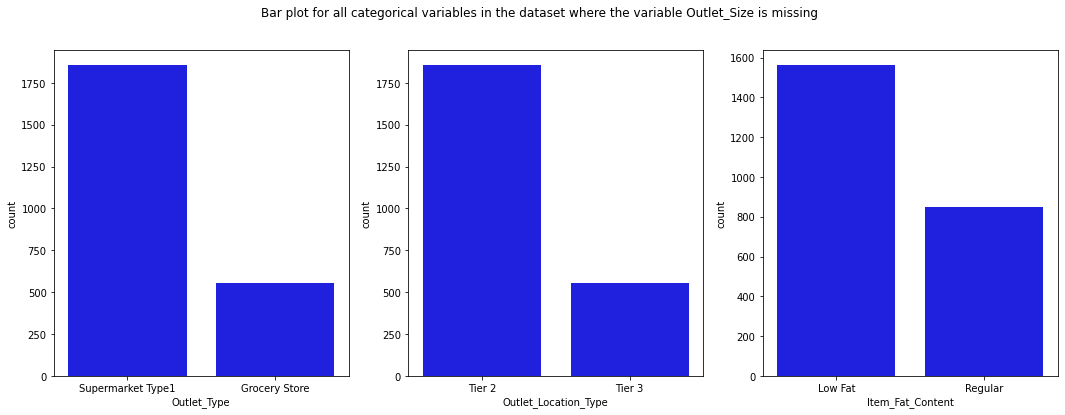

In [24]:
# Observe the distribution of variables on the set with missing Outlet_Size
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
  
fig.suptitle('Bar plot for all categorical variables in the dataset where the variable Outlet_Size is missing')

sns.countplot(ax=axes[0], x='Outlet_Type', data=outlet_size_missing_data, color='blue', 
              order=outlet_size_missing_data['Outlet_Type'].value_counts().index, );

sns.countplot(ax=axes[1], x='Outlet_Location_Type', data=outlet_size_missing_data, color='blue', 
              order=outlet_size_missing_data['Outlet_Location_Type'].value_counts().index);

sns.countplot(ax=axes[2], x='Item_Fat_Content', data=outlet_size_missing_data, color='blue', 
              order=outlet_size_missing_data['Item_Fat_Content'].value_counts().index);

**Observations:**
- We can see that wherever `Outlet_Size` is missing, the majority of entries have `Outlet_Type` set as **Supermarket Type 1**, `Outlet_Location_Type` as **Tier 2**, and `Item_Fat_Content` as **Low Fat**.

Now let's create a crosstab of all of the above categorical variables against the column `Outlet_Size` where we want to impute the missing values.

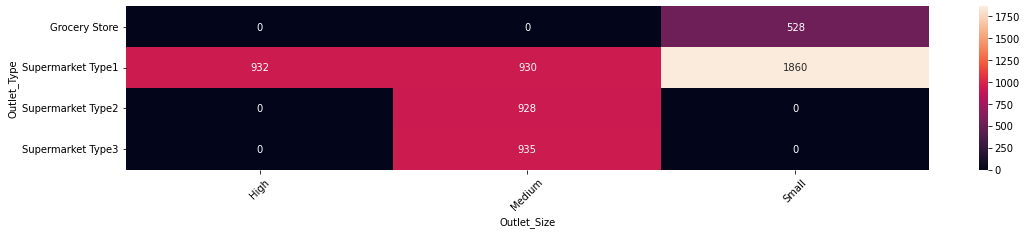

In [25]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Outlet_Type'], columns=outlet_size_data['Outlet_Size']), annot=True, fmt='g')
plt.xticks(rotation=45);

**Observations:**
- We can see from the crosstab that all the grocery stores have `Outlet_Size` as `Small`.
- We can also see that all of the `Supermarket Type 2` and `Supermarket Type 3` entries have `Outlet_Size` as `Medium`.

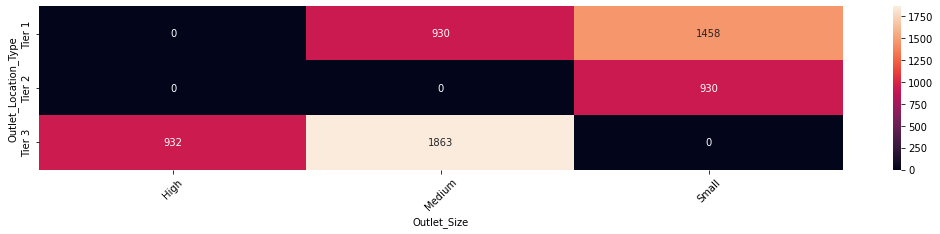

In [26]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Outlet_Location_Type'], columns=outlet_size_data['Outlet_Size']), annot=True, fmt='g')
plt.xticks(rotation=45);

**Observations:**
- We can see that all of the Tier 2 stores have `Outlet_Size` as `Small`.

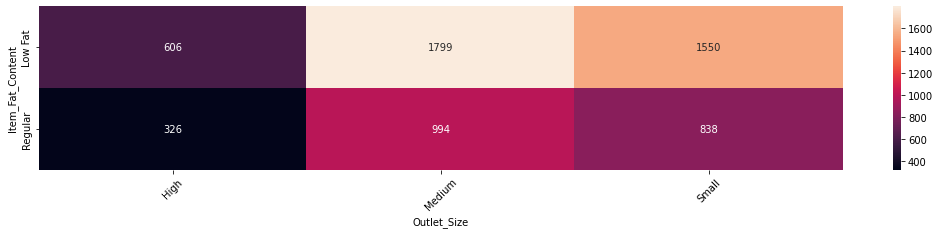

In [28]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Item_Fat_Content'], columns=outlet_size_data['Outlet_Size']), annot=True, fmt='g')
plt.xticks(rotation=45);

**Observations:**
- There is no clear pattern between the variables `Item_Fat_Content` and `Outlet_Size`, which is unlike what we have seen between `Outlet_Type` and `Outlet_Location_Type`

Now we will use the patterns we have observed from the variables `Outlet_Type` and `Outlet_Location_Type` to impute the missing values for the column `Outlet_Size`.

We will be identifying the indices in the dataframe where `Outlet_Size` is null/missing and `Outlet_Type` is Grocery Store. We can replace those missing values with the value Small, based on the pattern we have identified in above crosstab visualization.

Similarly we can identify the indices in the dataframe where `Outlet_Size` is null/missing and `Outlet_Location_Type` is Tier 2, and impute those missing values.

In [29]:
grocery_store_indices = train_df[train_df['Outlet_Size'].isnull()].query("Outlet_Type == 'Grocery Store'").index
tier_2_indices = train_df[train_df['Outlet_Size'].isnull()].query("Outlet_Location_Type == 'Tier 2'").index

Now are updating those indices for the column `Outlet_Size` with the value Small.

In [30]:
train_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
train_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

We also need to perform the same transformation on testing dataset.

In [31]:
grocery_store_indices = test_df[test_df['Outlet_Size'].isnull()].query("Outlet_Type == 'Grocery Store'").index
tier_2_indices = test_df[test_df['Outlet_Size'].isnull()].query("Outlet_Location_Type == 'Tier 2'").index

In [32]:
test_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
test_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

Now that we have imputed the missing values, let's check again to see if we still have missing values in both the training and testing datasets.

In [33]:
train_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [34]:
test_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

As we can see that there are no more missing values in the datasets.

### Feature Engineering

We have spent some time understanding the data and preparing the data by treating missing values. Before we begin modeling, we have observed that there may be certain features which are not currently present in the dataset. We can  these features using the existing columns, which can help us predict sales.

This step of creating a new feature from the existing features in the dataset is known as **Feature Engineering**. Let's create a new feature that attempts to look at the age of the store. Let's begin by stating a hypothesis:

**As the store gets older, the sales increase.**

We know the establishment year and this data is collected in 2013, so we can determine the age by subtracting establishment year from 2013.

We will create the a new feature `Outlet_Age` which indicates that how old the outlet is.

In [35]:
train_df['Outlet_Age'] = 2013 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Age'] = 2013 - test_df['Outlet_Establishment_Year']

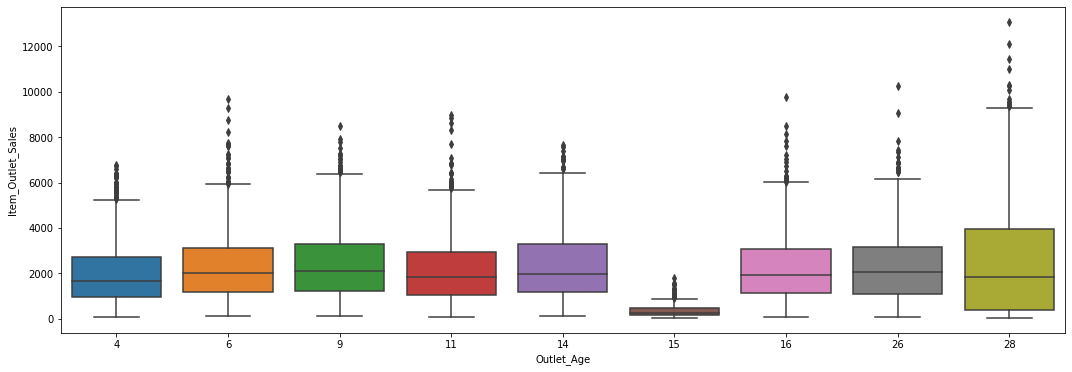

In [36]:
fig= plt.figure(figsize=(18, 6))
sns.boxplot(x='Outlet_Age', y='Item_Outlet_Sales', data=train_df);

**Observations:**
- The hypothesis that we have stated above: **As the store gets older, the sales increase** does not seem to hold any water based on the above plot.
- For different aged stores the sales have a relatively similar distribution.
- For now let's keep this variable. We can revisit this variable again later when we construct the model. We can remove this variable by observing its significance later on.

## Modeling

Now that we have analyzed the variables in the dataset, we are now ready to start building the model. We have observed that not all of the independent variables are important to predict the outcome variable. However, at the beginning, we will use all of the variables when constructing the model. We can then decide from the model summary whether we will remove a variable from the model. Model building is an iterative task.

In [37]:
# Remove the outcome variable from the feature set and also the variable Outlet_Establishment_Year as we have created
# a new variable Outlet_Age
train_features = train_df.drop(['Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis=1)

# Store the outcome variable separately
train_target = train_df['Item_Outlet_Sales']

In linear models, whenever we have categorical variables as independent variables, we need to create **one-hot encoded** representations (i.e. dummy variables) of those categorical variables.

The below piece of code is creating dummy variables and we are removing the first category in those variables which is known as **reference variable**. The reference variable helps to interpret the linear regression which we will see later.

In [38]:
# Create one-hot encoded representations of the categorical variables
train_features = pd.get_dummies(train_features, drop_first=True)
# Print the first 5 entries to observe this change
train_features.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,15,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,8.93,0.000000,53.8614,26,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


**Observations:**
- Notice the column names of all the categorical variables, and also the overall number of columns has increased after we created the dummy variables
- For each of those categorical variables, the first category has been removed. For instance, the category `Low Fat` of the categorical variable `Item_Fat_Content` has been removed, as it became the `reference variable`, and we only have the category `Regular` as a new column `Item_Fat_Content_Regular`. So in this instance, 0 is equivalent to `Low Fat` and 1 is equivalent to `Regular`.

Now we can scale the numerical variables in the dataset to have the same range. If we don't do this, then the model will be biased towards a variable where we have a higher range and the model will not learn from the variables which values with lower range.

There are many ways to do scaling, here we are using the `MinMaxScaler` as we have both categorical and numerical variables in the dataset and we don't want to change the dummy encodings of the categorical variables that we have already created. For more information on different ways of doing scaling, refer to the **section 6.3.1** of this page [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler).

In [39]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)

# The scaler returns the data in array format, below we are converting back to a pandas dataframe format
train_features_scaled = pd.DataFrame(train_features_scaled, index=train_features.index, columns=train_features.columns)

# Print the first 5 entries of the scaled dataframe
train_features_scaled.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.282525,0.048866,0.927507,0.416667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.081274,0.058705,0.072068,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.770765,0.051037,0.468288,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.871986,0.000000,0.640093,0.458333,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.000000,0.095805,0.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Now that the dataset is prepared, we are ready to build the model using the `statsmodels` package.

In [40]:
# Add the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# Call the OLS algorithm on the train features and target variable datasets
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# Fit the model
ols_res_0 = ols_model_0.fit()

Now let's observe the summary of the model.

In [41]:
ols_res_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     405.8
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:40:51   Log-Likelihood:                -71993.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8495   BIC:                         1.442e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             185.7376    508.418      0.365      0.715    -810.886    1182.361
Item_Weight                        -4.7947     48.646     -0.099      0.921    -100.152      90.563
Item_Visibility                   -99.3563     81.718     -1.216      0.224    -259.544      60.831
Item_MRP                         3668.7061     46.595     78.735      0.000    3577.368    3760.044
Outlet_Age                       -745.4095    250.312     -2.978      0.003   -1236.082    -254.737
Item_Fat_Content_Regular           40.3266     28.245      1.428      0.153     -15.040      95.693
Item_Type_Breads                    5.8168     84.088      0.069      0.945    -159.016     170.650
Item_Type_Breakfast                 7.1348    116.664      0.061      0.951    -221.554     235.824
Item_Type_Canned                   26.9216     62.797      0.429      0.668     -96.177     150.020
Item_Type_Dairy                   -40.6540     62.253     -0.653      0.514    -162.685      81.377
Item_Type_Frozen Foods            -27.6433     58.894     -0.469      0.639    -143.091      87.804
Item_Type_Fruits and Vegetables    29.3880     54.981      0.535      0.593     -78.389     137.165
Item_Type_Hard Drinks              -1.4967     90.234     -0.017      0.987    -178.377     175.384
Item_Type_Health and Hygiene      -11.8328     68.040     -0.174      0.862    -145.208     121.542
Item_Type_Household               -38.8140     59.949     -0.647      0.517    -156.329      78.701
Item_Type_Meat                      0.4500     70.683      0.006      0.995    -138.105     139.005
Item_Type_Others                  -22.9184     98.664     -0.232      0.816    -216.324     170.488
Item_Type_Seafood                 186.0471    148.081      1.256      0.209    -104.229     476.323
Item_Type_Snack Foods             -10.5099     55.274     -0.190      0.849    -118.860      97.841
Item_Type_Soft Drinks             -27.3904     70.208     -0.390      0.696    -165.016     110.235
Item_Type_Starchy Foods            22.8708    103.083      0.222      0.824    -179.197     224.939
Outlet_Size_Medium               -728.1471    274.680     -2.651      0.008   -1266.586    -189.708
Outlet_Size_Small                -762.6887    254.944     -2.992      0.003   -1262.441    -262.937
Outlet_Location_Type_Tier 2      -168.6244     87.638     -1.924      0.054    -340.417       3.168
Outlet_Location_Type_Tier 3      -421.5537    152.014     -2.773      0.006    -719.538    -123.569
Outlet_Type_Supermarket Type1    1515.9958    140.028     10.826      0.000    1241.507    1790.485
Outlet_Type_Supermarket Type2    1252.3893    123.874     10.110      0.000    1009.566    1495.213
Outlet_Type_Supermarket Type3    3724.4819    176.037     21.157      0.000    3379

- We can see that `R-squared` for the model is `0.563`. 
- Not all the variables are statistically significant to predict the outcome variable. To check which are statistically significant or have predictive power to predict the target variable, we need to check the `p-value` against all the independent variables.

**Interpreting the Regression Results:**

1. **Adjusted. R-squared**: It reflects the fit of the model.
    - R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adj. R-squared is **0.562**

2. **coeff**: It represents the change in the output Y due to a change of one unit in the variable (everything else held constant).
3. **std err**: It reflects the level of accuracy of the coefficients.
    - The lower it is, the more accurate the coefficients are.
4. **P >|t|**: It is p-value.
   
   * Pr(>|t|) : For each independent feature there is a null hypothesis and alternate hypothesis 

    Ho : Independent feature is not significant 
   
    Ha : Independent feature is significant 
    
   * A p-value of less than 0.05 is considered to be statistically significant.

   
5. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

To understand in detail, how p-values can help to identify statistically significant variables to predict the sales, we need to understand the hypothesis testing framework here: 

In the following example, we are showing the null hypothesis between the independent variable `Outlet_Size` and the dependent variable `Item_Outlet_Sales` to identify if there is any relationship between them or not.

- **Null hypothesis:** There is nothing going on or there is no relationship between variables `Outlet_Size` and `Item_Outlet_Sales` 

<center>$\mu_{\text {outlet size }=\text { High }}=\mu_{\text {outlet size }=\text { Medium }}=\mu_{\text {outlet size }=\text { Small }}$</center>

- **Alternate hypothesis:** There is something going on, because of which there is a relationship between variables `Outlet_Size` and `Item_Outlet_Sales` i.e. - 

<center>$\mu_{\text {outlet size = High }} \neq \mu_{\text {outlet size = Medium }} \neq \mu_{\text {outlet size }=\text { small }}$</center>

and from the above model summary if p-value less than the significance level 0.05, that means we will reject the null hypothesis in favor of alternate hypothesis. In other words, we have enough statistical evidence that there is relationship exists between the variables `Outlet_Size` and `Item_Outlet_Sales`

Based on this above analysis, if we observe the above model summary, we can see only some variables or some categories of a categorical variables have p-value lower than 0.05

### Feature Selection

As we have discussed above, that not all variables are statistically significant to predict the dependent/outcome variable. In this step, we are selecting only the relevant features `based on p-value` which we discussed above and eliminating all the other variables that are not important.

In [42]:
# Select only the relevant features
train_features_2 = train_df[['Item_MRP', 'Outlet_Age', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']]

Again we need to create dummy variables for the categorical variables.

In [43]:
# Obtain one hot encoded values for the relevant categorical features
train_features_2 = pd.get_dummies(train_features_2, drop_first=True)
train_features_2.head()

,Item_MRP,Outlet_Age,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,249.8092,14,1,0,0,0,1,0,0
1,48.2692,4,1,0,0,1,0,1,0
2,141.6180,14,1,0,0,0,1,0,0
3,182.0950,15,0,1,0,1,0,0,0
4,53.8614,26,0,0,0,1,1,0,0


Then we can scale the variables.

In [44]:
# Scale the relevant features
train_features_scaled_2 = scaler.fit_transform(train_features_2)
train_features_scaled_2 = pd.DataFrame(train_features_scaled_2, index=train_features_2.index, columns=train_features_2.columns)
train_features_scaled_2.head()

,Item_MRP,Outlet_Age,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.927507,0.416667,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.072068,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.468288,0.416667,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.640093,0.458333,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.095805,0.916667,0.0,0.0,0.0,1.0,1.0,0.0,0.0


And now build the model again, but this time with only taking the relevant variables based on p-values

In [45]:
# Add the intercept term
train_features_scaled_2 = sm.add_constant(train_features_scaled_2)
# Construct the model
ols_model_2 = sm.OLS(train_target, train_features_scaled_2)
# Fit the model
ols_res_2 = ols_model_2.fit()

In [46]:
ols_res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1217.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:46:17   Log-Likelihood:                -71998.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8513   BIC:                         1.441e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           139.5151    504.725      0.276      0.782    -849.868    1128.898
Item_MRP                       3667.9031     46.276     79.262      0.000    3577.192    3758.615
Outlet_Age                     -735.7980    250.035     -2.943      0.003   -1225.928    -245.668
Outlet_Size_Medium             -715.9299    274.383     -2.609      0.009   -1253.787    -178.073
Outlet_Size_Small              -752.5194    254.691     -2.955      0.003   -1251.776    -253.263
Outlet_Location_Type_Tier 2    -164.7302     87.524     -1.882      0.060    -336.299       6.839
Outlet_Location_Type_Tier 3    -414.9560    151.838     -2.733      0.006    -712.595    -117.317
Outlet_Type_Supermarket Type1  1534.2705    139.340     11.011      0.000    1261.130    1807.411
Outlet_Type_Supermarket Type2  1268.2890    123.308     10.286      0.000    1026.576    1510.002
Outlet_Type_Supermarket Type3  3731.8464    175.564     21.256      0.000    3387.699    4075.994
==============================================================================
Omnibus:                      960.769   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.231
Skew:                           0.667   Prob(JB):                         0.00
Kurtosis:                       5.160   Cond. No.                         95.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observations:**
- The R-Squared value did not change at all. It is still coming out to be 0.563 which implies that all other variables were not adding any value to the model.

Let's check the assumptions of the linear regression model.

### Checking for assumptions and rebuilding the model

In this step, we will check for the below assumptions in the model, to check if they hold true or not. If there is any issue, then we will rebuild the model after resolving those issues.

1. No multicollinearity among independent variables
2. Mean of residuals should be 0
3. Normality of error terms
4. Linearity of variables
5.  No heteroscedasticity

#### 1.) No multicollinearity among independent variables

* Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent.  If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

* There are different ways of detecting (or testing) multi-collinearity, one such way is Variation Inflation Factor.

* **Variance  Inflation  factor**:  Variance  inflation  factors  measures  the  inflation  in  the variances of the regression parameter estimates due to collinearities that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient βk is “inflated” by  the  existence  of  correlation  among  the  predictor variables in the model. 

* General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [47]:
# Drop the one with the highest VIF value and check the Adjusted-R Squared
vif_series_1 = pd.Series([variance_inflation_factor(train_features_scaled_2.values,i) for i in range(train_features_scaled_2.shape[1])],
                        index=train_features_scaled_2.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series_1))

Series before feature selection: 

const                            1703.138903
Item_MRP                            1.000182
Outlet_Age                         50.851534
Outlet_Size_Medium                110.890861
Outlet_Size_Small                 106.701575
Outlet_Location_Type_Tier 2        11.266788
Outlet_Location_Type_Tier 3        36.770793
Outlet_Type_Supermarket Type1      29.359000
Outlet_Type_Supermarket Type2       9.863086
Outlet_Type_Supermarket Type3      20.126350
dtype: float64



#### Removing Multicollinearity
 * To remove multicollinearity, we will drop the column that has VIF score greater than 5 and build the model again.

We can see that the variable `Outlet_Size_Medium` has the highest VIF, so in the next iteration we will remove this variable and build the model again.

In [48]:
# Drop the Outlet_Size_Medium variable and rebuild the model
train_features_scaled_3 = train_features_scaled_2.drop(['Outlet_Size_Medium'], axis=1)
ols_model_3 = sm.OLS(train_target, train_features_scaled_3)
ols_res_3 = ols_model_3.fit()

In [49]:
ols_res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1367.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:51:41   Log-Likelihood:                -72002.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8514   BIC:                         1.441e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1153.6485     95.520    -12.078      0.000   -1340.890    -966.407
Item_MRP                       3667.0969     46.290     79.219      0.000    3576.356    3757.837
Outlet_Age                     -116.5171     78.681     -1.481      0.139    -270.752      37.718
Outlet_Size_Small              -101.2256     50.634     -1.999      0.046    -200.481      -1.970
Outlet_Location_Type_Tier 2      24.4142     49.064      0.498      0.619     -71.764     120.592
Outlet_Location_Type_Tier 3     -34.7055     42.638     -0.814      0.416    -118.286      48.875
Outlet_Type_Supermarket Type1  1866.8788     56.288     33.167      0.000    1756.541    1977.217
Outlet_Type_Supermarket Type2  1465.6499     97.417     15.045      0.000    1274.690    1656.610
Outlet_Type_Supermarket Type3  3309.9199     68.391     48.397      0.000    3175.857    3443.983
==============================================================================
Omnibus:                      962.481   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.814
Skew:                           0.668   Prob(JB):                         0.00
Kurtosis:                       5.164   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let's check the VIF again.

In [50]:
vif_series_2 = pd.Series([variance_inflation_factor(train_features_scaled_3.values,i) for i in range(train_features_scaled_3.shape[1])],
                        index=train_features_scaled_3.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series_2))

Series before feature selection: 

const                            60.957867
Item_MRP                          1.000137
Outlet_Age                        5.032103
Outlet_Size_Small                 4.214391
Outlet_Location_Type_Tier 2       3.538163
Outlet_Location_Type_Tier 3       2.897614
Outlet_Type_Supermarket Type1     4.787661
Outlet_Type_Supermarket Type2     6.151776
Outlet_Type_Supermarket Type3     3.052102
dtype: float64



- VIF score for `Outlet_Type_Supermarket Type2` is the highest and more than 5. Let's remove this variable and build the model again.

In [51]:
# Drop the Outlet_Type_Supermarket Type 2 variable and rebuild the model
train_features_scaled_4 = train_features_scaled_3.drop(['Outlet_Type_Supermarket Type2'], axis=1)
ols_model_4 = sm.OLS(train_target, train_features_scaled_4)
ols_res_4 = ols_model_4.fit()

In [52]:
ols_res_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:53:32   Log-Likelihood:                -72113.
No. Observations:                8523   AIC:                         1.442e+05
Df Residuals:                    8515   BIC:                         1.443e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.5034     57.571      0.026      0.979    -111.351     114.357
Item_MRP                       3672.0092     46.898     78.298      0.000    3580.078    3763.940
Outlet_Age                     -965.3974     55.560    -17.376      0.000   -1074.308    -856.486
Outlet_Size_Small              -512.6249     43.176    -11.873      0.000    -597.261    -427.989
Outlet_Location_Type_Tier 2     -22.9907     49.607     -0.463      0.643    -120.232      74.251
Outlet_Location_Type_Tier 3      61.1836     42.713      1.432      0.152     -22.545     144.912
Outlet_Type_Supermarket Type1  1333.4061     44.290     30.106      0.000    1246.586    1420.226
Outlet_Type_Supermarket Type3  2905.4968     63.714     45.602      0.000    2780.602    3030.391
==============================================================================
Omnibus:                      916.516   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.548
Skew:                           0.655   Prob(JB):                         0.00
Kurtosis:                       5.032   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check the VIF once again.

In [53]:
vif_series_3 = pd.Series([variance_inflation_factor(train_features_scaled_4.values,i) for i in range(train_features_scaled_4.shape[1])],
                        index=train_features_scaled_4.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series_3))

Series before feature selection: 

const                            21.573179
Item_MRP                          1.000087
Outlet_Age                        2.444472
Outlet_Size_Small                 2.985318
Outlet_Location_Type_Tier 2       3.523572
Outlet_Location_Type_Tier 3       2.832871
Outlet_Type_Supermarket Type1     2.887798
Outlet_Type_Supermarket Type3     2.580609
dtype: float64



**Observations:**
- We have removed the multi-collinearity from the data, since all of the variables have VIF score less than 5 (except constant).
- Some of the variables in the model have become insignificant. Let's also drop these variables.

In [54]:
# Drop the insignificant features and rebuild the model
train_features_scaled_5 = train_features_scaled_4.drop(['Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3'], axis=1)
ols_model_5 = sm.OLS(train_target, train_features_scaled_5)
ols_res_5 = ols_model_5.fit()

In [55]:
ols_res_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2087.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:55:12   Log-Likelihood:                -72114.
No. Observations:                8523   AIC:                         1.442e+05
Df Residuals:                    8517   BIC:                         1.443e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            59.1690     40.979      1.444      0.149     -21.161     139.499
Item_MRP                       3672.4152     46.897     78.307      0.000    3580.485    3764.345
Outlet_Age                     -941.5194     42.449    -22.180      0.000   -1024.730    -858.309
Outlet_Size_Small              -553.5221     27.615    -20.044      0.000    -607.655    -499.390
Outlet_Type_Supermarket Type1  1291.9098     29.987     43.082      0.000    1233.128    1350.692
Outlet_Type_Supermarket Type3  2884.9499     53.450     53.975      0.000    2780.175    2989.724
==============================================================================
Omnibus:                      918.244   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2083.648
Skew:                           0.656   Prob(JB):                         0.00
Kurtosis:                       5.036   Cond. No.                         7.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observations:**
- All the variables are significant now and the R-Squared has not decreased by much. It is still coming out to be 0.55.

Let's check the other assumptions.

### 2.) Mean of residuals should be 0 and normality of error terms

In [56]:
# Obtain the residual values
residual = ols_res_5.resid

In [57]:
# Calculate the mean of the residuals
residual.mean()

3.653398493165418e-12

The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

### 3.) Test for Normality

**What is the test?**

* Error terms/Residuals should be normally distributed

* If the error terms are non- normally distributed, confidence intervals may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares.

**What do non-normality indicate?**

* It suggests that there are a few unusual data points which must be studied closely to make a better model.

**How to Check the Normality?**

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Other test to check for normality : Shapiro-Wilk test.

**What is the residuals are not-normal?**

* We can apply transformations like log, exponential, arcsinh, etc as per our data

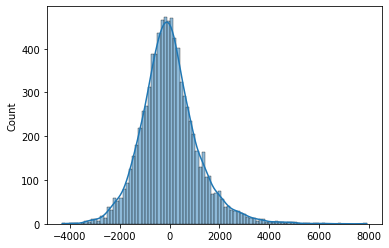

In [58]:
# Plot a histogram of the residuals
sns.histplot(residual, kde=True)

We can see that the error terms are normally distributed. The assumption of normality is satisfied.

### 4.) Linearity of variables

It states that the predictor variables must have a linear relation with the dependent variable.

To test this assumption, we will plot the residuals and fitted values to ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

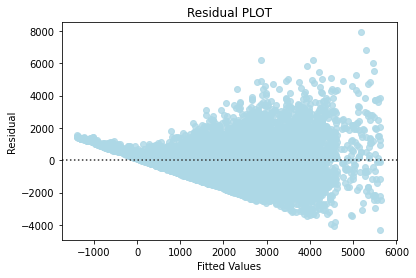

In [59]:
# Obtain the predicted values
fitted = ols_res_5.fittedvalues

# Plot the predicted values against the residuals
# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

**Observations:**
- We can see that there is some pattern in fitted values and residuals i.e. the residuals are not randomly distributed.
- Let's try to fix this. We can apply the log transformation on the target variable and try to build a new model.

In [60]:
# Perform a log transformation on the target variable
train_target_log = np.log(train_target)

In [61]:
# Fit a new model with the transformed target variable
ols_model_6 = sm.OLS(train_target_log, train_features_scaled_5)
ols_res_6 = ols_model_6.fit()

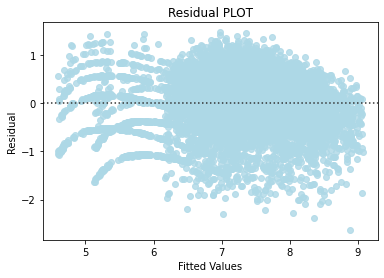

In [62]:
# Obtain the predicted and residual values
fitted = ols_res_6.fittedvalues
residual1 = ols_res_6.resid

# Plot the predicted values against the residuals
# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residual1, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

**Observations**
- We can see that there is no longer a pattern in the residuals vs fitted values, so the linearity assumption is satisfied.
- Let's check the model summary of the latest model we have fit. 

In [63]:
ols_res_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3540.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:00:15   Log-Likelihood:                -7446.2
No. Observations:                8523   AIC:                         1.490e+04
Df Residuals:                    8517   BIC:                         1.495e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.1604      0.021    296.656      0.000       6.120       6.201
Item_MRP                          1.9623      0.024     82.572      0.000       1.916       2.009
Outlet_Age                       -1.0049      0.022    -46.717      0.000      -1.047      -0.963
Outlet_Size_Small                -0.5812      0.014    -41.530      0.000      -0.609      -0.554
Outlet_Type_Supermarket Type1     1.2249      0.015     80.605      0.000       1.195       1.255
Outlet_Type_Supermarket Type3     1.9662      0.027     72.594      0.000       1.913       2.019
==============================================================================
Omnibus:                      515.126   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.893
Skew:                          -0.620   Prob(JB):                    6.70e-135
Kurtosis:                       3.448   Cond. No.                         7.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The model performance has improved significantly. The R-Squared has increased from 0.55 to 0.675.

Let's check the final assumption.

### 5.) No heteroscedasticity

#### Test for homoscedasticity

* **homoscedasticity** - If the variance of the residuals are symmetrically distributed across the regression line, then the data is said to homoscedastic.

* **heteroscedasticity** - If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form an arrow shape or any other non symmetrical shape.

We will use the Goldfeld–Quandt test to check homoscedasticity.

**Null hypothesis :** Residuals are homoscedastic

**Alternate hypothesis :** Residuals are hetroscedastic

In [64]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [65]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(train_target_log, train_features_scaled_5)
lzip(name, test)

[('F statistic', 0.9586092015528055), ('p-value', 0.9159984235118589)]

- As we can see from the above test the p-value is greater than 0.05, so we fail to reject the null-hypothesis. This tells us that the residuals are **homoscedastic**.

We have verified all the assumptions of the linear regression model. Looking at the summary coefficients from the last model we created, we obtain the final equation of the model, which is as follows:

**$\log ($ Item_Outlet_Sales $)$ $=6.1604 + 1.9623 *$ Item_MRP - $1.0049 *$ Outlet_Age $ - 0.5812 *$ Outlet_Size_Small $+1.2249 *$ Outlet_Type_Supermarket Type1 $ + 1.9662 *$ Outlet_Type_Supermarket Type3**

## Predicting with the Testing Dataset

Now we have finalized the model, so let's prepare the testing dataset to predict the output.

In [67]:
without_const = train_features_scaled_2.iloc[:,1:]
# Construct one-hot encoded features for the categorical variables
test_features = pd.get_dummies(test_df, drop_first=True)
# Obtain the testing data features without the constant term
test_features = test_features[list(without_const)]
# Scale the features
test_features_scaled = scaler.transform(test_features)
# Reform the scaled feature array into a pandas dataframe
test_features_scaled = pd.DataFrame(test_features_scaled, columns=without_const.columns)
# Add the intercept term
test_features_scaled = sm.add_constant(test_features_scaled)
# Print the first 5 entries of the prepared testing dataset
test_features_scaled.head()

,const,Item_MRP,Outlet_Age,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.0,0.325012,0.416667,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.237819,0.083333,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.893316,0.458333,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.525233,0.083333,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.861381,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [69]:
# Restrict the columns to the same columns that we determined work for the training dataset
test_features_scaled = test_features_scaled[train_features_scaled_5.columns]

### Evaluation Metric

#### R-squared

The R-squared metric gives us an indication that how good/bad our model is from a baseline model. Here, we have explained ~98% variance in the data as compared to the baseline model when there is no independent variable.

In [70]:
print(ols_res_6.rsquared)

0.6751411673487511


#### Mean Squared Error

This metric measures the average of the squares of the errors i.e. the average squared difference between the estimated values and the actual value.

In [71]:
print(ols_res_6.mse_resid)

0.3362667409042841


#### Root Mean Squared Error

This metric is same as the above but instead of square root of MSE to get RMSE

In [72]:
print(np.sqrt(ols_res_6.mse_resid))

0.5798851100901662


Below we are checking the cross validation score to identify if the model that we have built is `underfitted`, `overfitted` or `just right` model.

In [73]:
# Fit a linear model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression()                                    

cv_Score11 = cross_val_score(linearregression, train_features_scaled_5, train_target_log, cv = 10)
cv_Score12 = cross_val_score(linearregression, train_features_scaled_5, train_target_log, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.673 (+/- 0.058)
Mean Squared Error: 0.337 (+/- 0.030)


**Observations:**
- The R-Squared on the cross validation is 0.673 which is almost similar to the R-Squared on the training dataset.
- And the MSE on cross validation is 0.337 which is almost similar to the R-Squared on the training dataset.

It seems like that our model is `just right`. It is giving a generalized performance.

Since this model that we have developed is a linear model, which is not capable of capturing non-linear patterns in the data, so we may want to build more advanced regression model which can capture the non-linearities in the data and improve this model further. But that is out of scope for this project.

### Predicting on the test dataset

Now that our model is completed, we can now use this to predict the sales in our test data.

In [74]:
# Test predictions will be on a log scale
test_predictions = ols_res_6.predict(test_features_scaled)

# Convert the log scale predictions to its original scale
test_predictions_inverse_transformed = np.exp(test_predictions)

**NOTE:** The output of this model is in log scale. So after prediction we need to transform this value in log back to its original scale by doing inverse of log transformation i.e. taking exponentiation.</font>

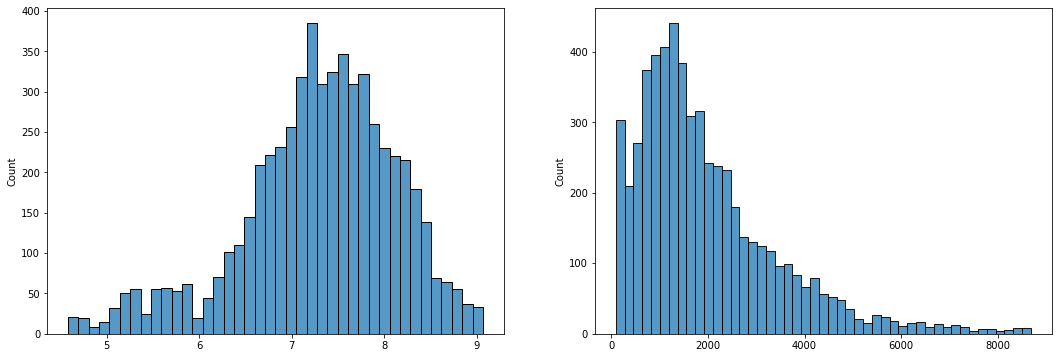

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(test_predictions, ax=ax[0]);
sns.histplot(test_predictions_inverse_transformed, ax=ax[1]);

### Conclusion and Recommendations

- We performed EDA - univariate and bivariate analysis on all the variables in the dataset
- We then performed missing values treatment using relationship between variables
- We started the model building the process with all the features
- We analyzed the model summary report
- Then we checked for different assumptions of linear regression
- And we then fixed the model iteratively if any assumptions did not hold true
- Then we evaluated the model using different evaluation metrics

Lastly below is the model equation:

**$\log ($ Item_Outlet_Sales $)$ $= 6.1604 + 1.9623 *$ Item_MRP - $1.0049 *$ Outlet_Age $ - 0.5812 *$ Outlet_Size_Small $+1.2249 *$ Outlet_Type_Supermarket Type1 $ + 1.9662 *$ Outlet_Type_Supermarket Type3**

- From this above equation, we can interpret that with one unit change in the variable `Item_MRP`, the outcome variable log of `Item_Outlet_Sales` increases by 1.9623 units. So if we want to increase sales we may want to store higher MRP items in the high visibility area.

- On an average, the log sales of stores with outlet size small is 0.5812 less than the log sales of outlet size high (remember the **reference variable**, here for the variable outlet size - **the category high was the reference variable which we dropped at the time of creating the dummy variable**). So when we are interpreting the coefficients of categorical variables we need to compare them against its reference variable. So the recommendation to the management would be to focus more on the larger stores. Maybe they can focus on having more inventory in larger stores as compared to others as we don't want to loose on revenue because unavailability of items there.

- On an average, the log sales of stores with type Supermarket type 1 is 1.2249 more than the log sales of stores with type grocery stores (the **reference variable** for this categorical variable **Outlet_Type**, here is **grocery store**). And similarly for Supermarket Type 3, on an average, have 1.9662 times more log sales than grocery stores.

##Recommendations
So after interpreting this linear regression equation it is clear that large stores of supermarket type 3 have more sales than others. So we want to maintain or improve the sales in these stores. And for the remaining stores we may want to make strategies to improve the sales, perhaps by providing better customer service, better training for the staff in these stores, providing more visibility of high MRP item, etc.